# Trans-effect validation: comparison with FACS screens

In [3]:
import numpy as np
import anndata
import pandas as pd
import scanpy as sc

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

Plotting utils

## Read DE analysis outputs

In [1]:
datadir = '/Users/rzhu/Gladstone Dropbox/Ronghui Zhu/GRNPerturbSeq/3_expts/processed_data/CD4iR1_Psomagen/'
experiment_name = 'CD4iR1_Psomagen'

In [15]:
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results.h5ad')
# Annotate zscore
adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 50)] = 50
adata_de.obs['target_contrast'].nunique()

9191

## Process FACS screen results

In [16]:
def get_mageck_pval(df, lfc_col='neg|lfc', pos_pval_col='pos|p-value', neg_pval_col='neg|p-value'):
    # Create a copy to avoid modifying the original DataFrame
    result_df = df.copy()
    
    result_df['pvalue'] = np.nan
    
    for idx, row in result_df.iterrows():
        log_fc = row[lfc_col]
        
        # Select the appropriate p-value based on the direction of log_fc
        if log_fc > 0:
            p_value = row[pos_pval_col]
        elif log_fc < 0:
            p_value = row[neg_pval_col]
        else:
            # If log_fc is exactly 0, standard error is undefined
            continue
        
        # Convert p-value to z-score (handling potential invalid p-values)
        if 0 <= p_value < 1:
            result_df.at[idx, 'pvalue'] = p_value
    
    return result_df

In [17]:
keep_mageck_columns = ['target', 'effect_size', 'num', 'neg|goodsgrna',
       'pos|goodsgrna', 'pvalue', 'phenotype', 'perturbation_type', 'downstream_gene']

In [31]:
Schmidt2022_data = pd.read_csv('../../metadata/SchmidtSteinhart2022_CRISPRi_screen_gene_phenotypes.csv', index_col=0)
Schmidt2022_data['phenotype'] = np.where(Schmidt2022_data['phenotype'] == 'Prim.CRi.CD4.IL2', 'CD4+ IL2', 'CD8+ IFNg')
Schmidt2022_data['downstream_gene'] = np.where(Schmidt2022_data['phenotype'] == 'CD4+ IL2', 'IL2', 'IFNG')
Schmidt2022_data = Schmidt2022_data[keep_mageck_columns].copy()
Schmidt2022_data = Schmidt2022_data[Schmidt2022_data['downstream_gene']=='IL2']
Schmidt2022_data.head()

,target,effect_size,num,neg|goodsgrna,pos|goodsgrna,pvalue,phenotype,perturbation_type,downstream_gene
37860,VAV1,-2.9160,12,12,0,2.613800e-07,CD4+ IL2,CRISPRi,IL2
37861,LCP2,-1.8811,12,12,0,2.613800e-07,CD4+ IL2,CRISPRi,IL2
37862,CD3G,-2.6665,12,12,0,2.613800e-07,CD4+ IL2,CRISPRi,IL2
37863,IL2,-2.6101,12,11,0,2.613800e-07,CD4+ IL2,CRISPRi,IL2
37864,CD3D,-2.4943,12,10,0,2.613800e-07,CD4+ IL2,CRISPRi,IL2


In [33]:
# Supplementary table 8
FOXP3_data = pd.read_csv('../../metadata/Umhoefer2025_FOXP3_Teff.csv')
FOXP3_data['perturbation_type'] = 'CRISPRn'
FOXP3_data['phenotype'] = 'CD4+ FOXP3'
FOXP3_data['downstream_gene'] = 'FOXP3'
FOXP3_data = get_mageck_pval(FOXP3_data)
FOXP3_data = FOXP3_data.rename({'id':'target', 'neg|lfc':'effect_size', 'neg|lfc':'effect_size'}, axis=1)[keep_mageck_columns]
FOXP3_data.head()

,target,effect_size,num,neg|goodsgrna,pos|goodsgrna,pvalue,phenotype,perturbation_type,downstream_gene
0,Non-Targeting,0.00000,593,0,0,NaN,CD4+ FOXP3,CRISPRn,FOXP3
1,FOXO1,1.82020,4,0,4,0.000004,CD4+ FOXP3,CRISPRn,FOXP3
2,PTEN,1.13060,4,0,4,0.000004,CD4+ FOXP3,CRISPRn,FOXP3
3,GATA3,1.39490,4,0,4,0.000004,CD4+ FOXP3,CRISPRn,FOXP3
4,NFKB2,0.97018,4,0,4,0.000004,CD4+ FOXP3,CRISPRn,FOXP3


In [34]:
# Freimer 2022 - Supplementary table 2
Fremer_IL2RA_data = pd.read_csv('../../metadata/Freimer2022_Screen.csv')
Fremer_IL2RA_data['perturbation_type'] = 'CRISPRn'
Fremer_IL2RA_data['downstream_gene'] = Fremer_IL2RA_data['screen'].copy()
# FOXP3_data['phenotype'] = 'CD4+ FOXP3'
Fremer_IL2RA_data = get_mageck_pval(Fremer_IL2RA_data)
Fremer_IL2RA_data = Fremer_IL2RA_data.rename({'id':'target', 'neg|lfc':'effect_size', 'neg|lfc':'effect_size', 'screen':'phenotype'}, axis=1)[keep_mageck_columns]
Fremer_IL2RA_data.head()

,target,effect_size,num,neg|goodsgrna,pos|goodsgrna,pvalue,phenotype,perturbation_type,downstream_gene
0,Non-Targeting,0.0000,593,0,0,NaN,IL2RA,CRISPRn,IL2RA
1,IL2RA,2.6818,4,0,4,0.000004,IL2RA,CRISPRn,IL2RA
2,STAT5B,2.3375,4,0,4,0.000004,IL2RA,CRISPRn,IL2RA
3,FOXP1,1.6035,4,0,4,0.000004,IL2RA,CRISPRn,IL2RA
4,STAT5A,1.2474,4,0,4,0.000004,IL2RA,CRISPRn,IL2RA


In [35]:
# Arce 2025 - Supplementary table 1
Arce_IL2RA_data = pd.read_csv('../../metadata/Arce2025_Screen.csv')
# Melt the dataframe to convert columns with suffixes into a longer format
# Identify columns with suffixes like '.Resting_Teff', '.Resting_Treg'
suffixes = [col.split('.')[-1] for col in Arce_IL2RA_data.columns if '.' in col]
suffixes = list(set(suffixes))  # Get unique suffixes

# Create a list to store melted dataframes for each suffix
melted_dfs = []

for suffix in suffixes:
    # Get columns for this suffix
    suffix_cols = [col for col in Arce_IL2RA_data.columns if col.endswith('.' + suffix)]
    # Get base columns (without suffix)
    base_cols = [col.split('.')[0] for col in suffix_cols]
    
    # Create a subset with id and columns for this suffix
    subset = Arce_IL2RA_data[['id'] + suffix_cols].copy()
    # Rename columns to remove suffix
    rename_dict = {suffix_cols[i]: base_cols[i] for i in range(len(suffix_cols))}
    subset = subset.rename(columns=rename_dict)
    # Add condition column
    subset['phenotype'] = suffix
    
    melted_dfs.append(subset)

# Combine all melted dataframes
long_Arce_data = pd.concat(melted_dfs, ignore_index=True)
long_Arce_data['phenotype'] = long_Arce_data['phenotype'].astype(str) + '_IL2RA'
long_Arce_data['downstream_gene'] = 'IL2RA'
long_Arce_data['perturbation_type'] = 'CRISPRi'
# FOXP3_data['phenotype'] = 'CD4+ FOXP3'
long_Arce_data = get_mageck_pval(long_Arce_data)
long_Arce_data.head()
long_Arce_data = long_Arce_data.rename({'id':'target', 'neg|lfc':'effect_size', 'neg|lfc':'effect_size', 'screen':'phenotype'}, axis=1)[keep_mageck_columns]
long_Arce_data.head()

,target,effect_size,num,neg|goodsgrna,pos|goodsgrna,pvalue,phenotype,perturbation_type,downstream_gene
0,STAT5B,1.6277,4,0,4,0.000004,Resting_Treg_IL2RA,CRISPRi,IL2RA
1,IL2RA,2.8099,4,0,4,0.000004,Resting_Treg_IL2RA,CRISPRi,IL2RA
2,PTEN,2.3480,4,0,4,0.000004,Resting_Treg_IL2RA,CRISPRi,IL2RA
3,STAT5A,1.3463,4,0,4,0.000004,Resting_Treg_IL2RA,CRISPRi,IL2RA
4,FOXP1,1.3331,4,0,4,0.000004,Resting_Treg_IL2RA,CRISPRi,IL2RA


In [41]:
# Concatenate all FACS tables into one dataframe
# First, add a source column to each dataframe to track the origin
Schmidt2022_data['dataset'] = 'Schmidt2022'
FOXP3_data['dataset'] = 'Umhoefer2025'
Fremer_IL2RA_data['dataset'] = 'Freimer2022'
long_Arce_data['dataset'] = 'Arce2025'

# Concatenate all dataframes
all_FACS_data = pd.concat([
    Schmidt2022_data,
    FOXP3_data,
    #Fremer_IL2RA_data,
    #long_Arce_data
], ignore_index=True)

# Display the first few rows to verify the concatenation
print(f"Combined FACS data shape: {all_FACS_data.shape}")
all_FACS_data.head()


Combined FACS data shape: (20036, 10)


,target,effect_size,num,neg|goodsgrna,pos|goodsgrna,pvalue,phenotype,perturbation_type,downstream_gene,dataset
0,VAV1,-2.9160,12,12,0,2.613800e-07,CD4+ IL2,CRISPRi,IL2,Schmidt2022
1,LCP2,-1.8811,12,12,0,2.613800e-07,CD4+ IL2,CRISPRi,IL2,Schmidt2022
2,CD3G,-2.6665,12,12,0,2.613800e-07,CD4+ IL2,CRISPRi,IL2,Schmidt2022
3,IL2,-2.6101,12,11,0,2.613800e-07,CD4+ IL2,CRISPRi,IL2,Schmidt2022
4,CD3D,-2.4943,12,10,0,2.613800e-07,CD4+ IL2,CRISPRi,IL2,Schmidt2022


In [42]:
cond = 'Rest'
gene = 'IL2'
FACS_gene_id = adata_de.var_names[adata_de.var['gene_name'] == gene].tolist()[0]
effect_on_facs_gene = sc.get.obs_df(adata_de[adata_de.obs['culture_condition'] == cond], 
                                        ['target_contrast_gene_name', 'n_cells_target', FACS_gene_id], 
                                        layer='zscore')
effect_on_facs_gene.sort_values(FACS_gene_id).set_index('target_contrast_gene_name').loc['GATA3']

n_cells_target     539.000000
ENSG00000109471     -0.134965
Name: GATA3, dtype: float64

In [43]:
def compare_facs_to_perturbseq(adata_de, FACS_phenotype_df, phenotype, gene, cond, min_cells=50, facs_pval_threshold=0.05, perturbseq_pval_threshold=0.1, ax=None):
    """
    Compare FACS screen results with perturb-seq data for a specific gene and condition.
    
    Parameters:
    -----------
    adata_de : AnnData
        AnnData object containing differential expression results
    FACS_phenotype_df : pandas.DataFrame
        DataFrame containing FACS screen results
    phenotype : str
        The phenotype column value to filter from FACS data
    gene : str
        Gene symbol to analyze
    cond : str
        Culture condition to filter from adata_de
    min_cells : int, default=50
        Minimum number of cells required for a target
    facs_pval_threshold : float, default=0.05
        P-value threshold for FACS significance
    perturbseq_pval_threshold : float, default=0.1
        P-value threshold for perturb-seq significance
    ax : matplotlib.axes.Axes, default=None
        Axes object to plot on. If None, a new figure is created.
        
    Returns:
    --------
    tuple
        (plot_dataframe, correlation_all, correlation_significant, p_value)
    """
    # Get gene ID from gene name
    FACS_gene_id = adata_de.var_names[adata_de.var['gene_name'] == gene].tolist()[0]
    
    # Extract perturb-seq data for the gene
    effect_on_facs_gene = sc.get.obs_df(adata_de[adata_de.obs['culture_condition'] == cond], 
                                        ['target_contrast_gene_name', 'n_cells_target', FACS_gene_id], 
                                        layer='zscore')
    effect_on_facs_gene.columns = ['target', 'n_cells_target', 'perturbseq_log_fc']
    
    signif_on_facs_gene = sc.get.obs_df(adata_de[adata_de.obs['culture_condition'] == cond], 
                                        ['target_contrast_gene_name', 'n_cells_target', FACS_gene_id], 
                                        layer='adj_p_value')
    signif_on_facs_gene.columns = ['target', 'n_cells_target', 'perturbseq_pval']
    effect_on_facs_gene = pd.merge(effect_on_facs_gene, signif_on_facs_gene)
    
    # Extract FACS data for the phenotype
    facs_effect = FACS_phenotype_df.pivot(index='target', columns='phenotype', values='effect_size')[phenotype].reset_index()
    facs_effect.columns = ['target', 'facs_screen_zscore']
    facs_signif = FACS_phenotype_df.pivot(index='target', columns='phenotype', values='pvalue')[phenotype].reset_index()
    facs_signif.columns = ['target', 'facs_screen_pval']
    facs_effect = pd.merge(facs_effect, facs_signif)
    
    # Merge datasets
    pl_df = pd.merge(facs_effect, effect_on_facs_gene)
    pl_df = pl_df.dropna()
    
    # Add significance annotations
    pl_df['facs_significant'] = pl_df['facs_screen_pval'] < facs_pval_threshold
    pl_df['perturbseq_significant'] = pl_df['perturbseq_pval'] < perturbseq_pval_threshold
    pl_df = pl_df[pl_df['n_cells_target'] > min_cells]
    
    # Calculate correlation coefficient for all genes
    corr_all = pl_df['facs_screen_zscore'].corr(pl_df['perturbseq_log_fc'])
    
    # Calculate correlation coefficient for significant genes
    sig_genes = pl_df[pl_df['facs_significant']]
    corr_sig = sig_genes['facs_screen_zscore'].corr(sig_genes['perturbseq_log_fc']) if len(sig_genes) > 1 else float('nan')
    
    # Calculate p-value for correlation of all genes
    from scipy import stats
    _, p_value = stats.pearsonr(pl_df['facs_screen_zscore'], pl_df['perturbseq_log_fc'])
    
    # Calculate p-value for correlation of significant genes
    if len(sig_genes) > 1:
        _, p_value_sig = stats.pearsonr(sig_genes['facs_screen_zscore'], sig_genes['perturbseq_log_fc'])
    else:
        p_value_sig = float('nan')
    
    # Get dataset name from the FACS data
    dataset_name = FACS_phenotype_df[FACS_phenotype_df['phenotype'] == phenotype]['dataset'].iloc[0]
    
    # Create figure if ax is not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    # Add dotted lines at x=0 and y=0
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.7, linewidth=1.5)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.7, linewidth=1.5)
    
    # Plot non-significant points first
    sns.scatterplot(data=pl_df, 
                    x='facs_screen_zscore', y='perturbseq_log_fc', 
                    color='black', edgecolor='none', s=6, 
                    label=f'All regulators (n={len(pl_df[~pl_df["facs_significant"]])}) - r = {corr_all:.2f}, p = {p_value:.2e}',
                    ax=ax)
    
    # Plot significant points on top with different color
    sns.scatterplot(data=pl_df[pl_df['facs_significant']], 
                    x='facs_screen_zscore', y='perturbseq_log_fc', 
                    color='red', edgecolor='none', s=12, 
                    label=f'FACS significant (n={len(sig_genes)}) - r = {corr_sig:.2f}, p = {p_value_sig:.2e}' if not np.isnan(corr_sig) else 'Significant genes: insufficient data',
                    ax=ax)
    
    # Set axis labels with dataset information
    ax.set_xlabel(f'FACS screen logFC ({phenotype} - {dataset_name})', fontsize=14)
    ax.set_ylabel(f'Perturb-seq z-score ({gene})', fontsize=14)
    # Create legend with correlation information
    legend_text = [
        f'All regulators (n={len(pl_df[~pl_df["facs_significant"]])}) - r = {corr_all:.2f}, p = {p_value:.2e}',
        f'FACS significant (n={len(sig_genes)}) - r = {corr_sig:.2f}, p = {p_value_sig:.2e}' if not np.isnan(corr_sig) else 'Significant genes: insufficient data'
    ]
    
    # Create custom legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label=legend_text[0]),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label=legend_text[1])
    ]
    
    # Add legend outside the plot
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.15), fontsize=12)
    # Increase tick label font size
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    plt.tight_layout()
    
    return pl_df, corr_all, corr_sig, p_value


In [44]:
# Convert the dataframe to a list of tuples
phenotype_gene_pairs = list(all_FACS_data[['phenotype', 'downstream_gene']].drop_duplicates().itertuples(index=False, name=None))


In [45]:
phenotype_gene_pairs

[('CD4+ IL2', 'IL2'), ('CD4+ FOXP3', 'FOXP3')]

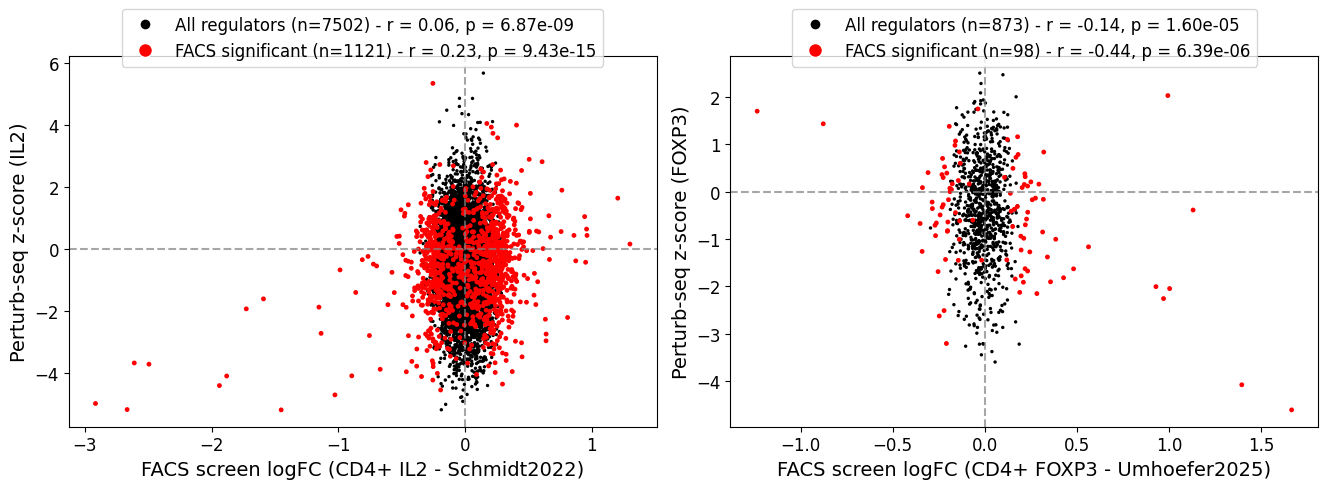

In [50]:
# Calculate the number of rows needed for a 3-column layout
num_pairs = len(phenotype_gene_pairs)
num_rows = (num_pairs + 2) // 3  # Ceiling division to ensure all pairs fit

# Create a figure with 3 columns and enough rows to fit all phenotype-gene pairs
fig, axes = plt.subplots(num_rows, 3, figsize=(20, 5 * num_rows))
# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot each phenotype-gene pair in its own subplot
for i, (p, g) in enumerate(phenotype_gene_pairs):
    if i < len(axes):  # Ensure we don't exceed the number of subplots
        pl_df, corr_all, corr_sig, p_value = compare_facs_to_perturbseq(
            adata_de, 
            all_FACS_data, 
            phenotype=p, 
            gene=g,
            cond='Stim8hr',
            ax=axes[i]
        )

# Hide any unused subplots
for j in range(num_pairs, len(axes)):
    axes[j].set_visible(False)
    
plt.tight_layout()